# Reading data


In [1]:
import os, seaborn as sns, pandas as pd, numpy as np

data = pd.read_csv("clean_data.csv", sep=",")
data.drop(data.columns[[0]], axis=1, inplace=True)
data.drop("ever_married", axis=1, inplace=True)
data.drop("residence_type", axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Private,Self-employed,children,formerly smoked,never smoked,smokes
0,1,0.816895,0,1,0.801265,0.301260,1,1,0,0,1,0,0
1,0,0.743652,0,0,0.679023,0.213169,1,0,1,0,0,1,0
2,1,0.975586,0,1,0.234512,0.254296,1,1,0,0,0,1,0
3,0,0.597168,0,0,0.536008,0.276060,1,1,0,0,0,0,1
4,0,0.963379,1,0,0.549349,0.156930,1,0,1,0,0,1,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5064 entries, 0 to 5063
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5064 non-null   int64  
 1   age                5064 non-null   float64
 2   hypertension       5064 non-null   int64  
 3   heart_disease      5064 non-null   int64  
 4   avg_glucose_level  5064 non-null   float64
 5   bmi                5064 non-null   float64
 6   stroke             5064 non-null   int64  
 7   Private            5064 non-null   int64  
 8   Self-employed      5064 non-null   int64  
 9   children           5064 non-null   int64  
 10  formerly smoked    5064 non-null   int64  
 11  never smoked       5064 non-null   int64  
 12  smokes             5064 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 514.4 KB


In [3]:
feature_cols = [col for col in list(data.columns) if col != "stroke"]
feature_cols

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'Private',
 'Self-employed',
 'children',
 'formerly smoked',
 'never smoked',
 'smokes']

## Test-train split

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [4]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.3, random_state=42
)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.stroke))

# Create the dataframes
X_train_ = data.loc[train_idx, feature_cols]
y_train_ = data.loc[train_idx, 'stroke']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'stroke']

In [5]:
y_train_.value_counts(normalize=True)

0    0.950903
1    0.049097
Name: stroke, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.950658
1    0.049342
Name: stroke, dtype: float64

In [7]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train_, y_train_.ravel())

In [8]:
y_train = pd.DataFrame(y_train)
X_train = pd.DataFrame(X_train, columns=X_train_.columns)

y_train.value_counts(normalize=True)

0    0.5
1    0.5
dtype: float64

# Logistic regression

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
# L1 regularized logistic regression
lr_l1 = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train, y_train)
# L2 regularized logistic regression
lr_l2 = LogisticRegression(C=1, penalty='l2', solver='liblinear').fit(X_train, y_train)


/Users/aleksandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aleksandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Errors on train set
coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]
y_pred_log_train = list()

for lab, mod in zip(coeff_labels, coeff_models):
    y_pred_log_train.append(pd.Series(mod.predict(X_train), name=lab))
    
y_pred_log_train = pd.concat(y_pred_log_train, axis=1)
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_train, y_pred_log_train[lab], average='weighted')
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_train, y_pred_log_train[lab])
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(
        label_binarize(y_train, classes=[0,1]),
        label_binarize(y_pred_log_train[lab], classes=[0,1]), 
        average='weighted'
        )
    
    metrics.append(pd.Series({
         'precision':precision,
         'recall':recall, 
         'fscore':fscore,
         'accuracy':accuracy,
         'auc':auc
        }, 
        name=lab
    ))

metrics = pd.concat(metrics, axis=1)
metrics

,lr,l1,l2
precision,0.809948,0.809871,0.809948
recall,0.806528,0.806528,0.806528
fscore,0.805993,0.806005,0.805993
accuracy,0.806528,0.806528,0.806528
auc,0.806528,0.806528,0.806528


In [11]:
# Predict the class and the probability for each
y_pred_log = list()

for lab, mod in zip(coeff_labels, coeff_models):
    y_pred_log.append(pd.Series(mod.predict(X_test), name=lab))
    
y_pred_log = pd.concat(y_pred_log, axis=1)
y_pred_log.head()

,lr,l1,l2
0,1,1,1
1,0,0,0
2,0,0,0
3,1,1,1
4,0,0,0


## Error metrics

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix


In [12]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred_log[lab], average='weighted')
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_log[lab])
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(
        label_binarize(y_test, classes=[0, 1]),
        label_binarize(y_pred_log[lab], classes=[0, 1]), 
        average='weighted'
        )
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred_log[lab])
    
    metrics.append(pd.Series(
        {'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, 
        name=lab
    ))

metrics = pd.concat(metrics, axis=1)
metrics

,lr,l1,l2
precision,0.945923,0.946037,0.945923
recall,0.759211,0.761842,0.759211
fscore,0.826653,0.828456,0.826653
accuracy,0.759211,0.761842,0.759211
auc,0.784867,0.786251,0.784867


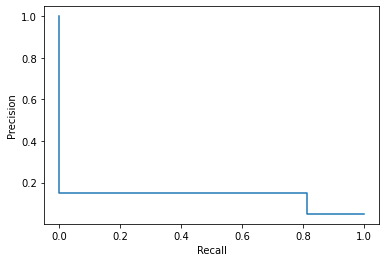

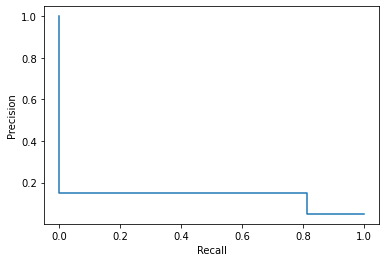

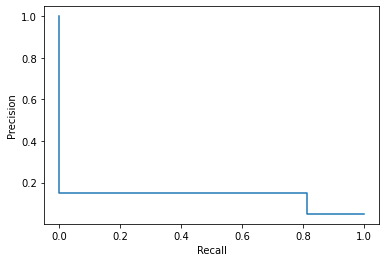

In [13]:
# Recall - precision curve

from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

for lab in coeff_labels:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_log[lab])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()

## Logistic regression - confusion matrix

Display or plot the confusion matrix for each model.

['lr', 'l1', 'l2']


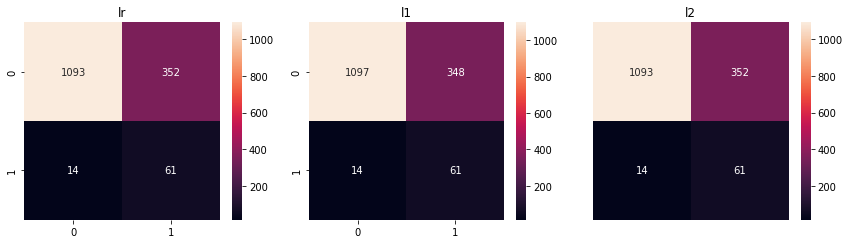

In [14]:
from matplotlib import pyplot as plt

fig, axList = plt.subplots(nrows=1, ncols=3)
axList = axList.flatten()
fig.set_size_inches(12, 3.5)

print(coeff_labels)

axList[-1].axis('off')

for ax, lab in zip(axList[:], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


# Support vector machines

In [15]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()
LSVC.fit(X_train, y_train)
y_pred_svm_train = pd.Series(LSVC.predict(X_train), name="SVM_train")
y_pred_svm = pd.Series(LSVC.predict(X_test), name="SVM")

/Users/aleksandra/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Errors in train set

# Precision, recall, f-score from the multi-class support function
precision, recall, fscore, _ = score(y_train, y_pred_svm_train, average='weighted')

# The usual way to calculate accuracy
accuracy = accuracy_score(y_train, y_pred_svm_train)

# ROC-AUC scores can be calculated by binarizing the data
auc = roc_auc_score(label_binarize(y_train, classes=[0,1]),
          label_binarize(y_pred_svm_train, classes=[0,1]), 
          average='weighted')

# Last, the confusion matrix
cm[lab] = confusion_matrix(y_train, y_pred_svm_train)

pd.Series({
     'precision':precision,
     'recall':recall, 
     'fscore':fscore,
     'accuracy':accuracy,
     'auc':auc
    }, 
    name="SVM_results"
)

precision    0.811411
recall       0.806528
fscore       0.805767
accuracy     0.806528
auc          0.806528
Name: SVM_results, dtype: float64

In [17]:
# Errors in test set

# Precision, recall, f-score from the multi-class support function
precision, recall, fscore, _ = score(y_test, y_pred_svm, average='weighted')

# The usual way to calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svm)

# ROC-AUC scores can be calculated by binarizing the data
auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
          label_binarize(y_pred_svm, classes=[0,1]), 
          average='weighted')

# Last, the confusion matrix
cm[lab] = confusion_matrix(y_test, y_pred_svm)

pd.Series({
     'precision':precision,
     'recall':recall, 
     'fscore':fscore,
     'accuracy':accuracy,
     'auc':auc
    }, 
    name="SVM_results"
)

precision    0.946515
recall       0.751316
fscore       0.821259
accuracy     0.751316
auc          0.787036
Name: SVM_results, dtype: float64

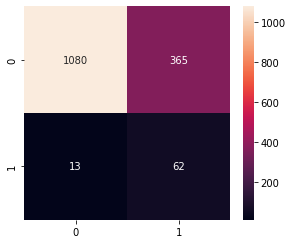

In [18]:
fig, axList = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(4.2, 3.5)

sns.heatmap(cm[lab], annot=True, fmt='d')
ax.set(title="SVM")
plt.tight_layout()

# Decision tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [20]:
dt.tree_.node_count, dt.tree_.max_depth

(1351, 25)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({
        'accuracy':accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
        },
        name=label
        )

In [22]:
# The error on the training and test data sets
y_train_tree_pred = dt.predict(X_train)
y_test_tree_pred = dt.predict(X_test)

train_test_full_error = pd.concat(
    [measure_error(y_train, y_train_tree_pred, 'train'), measure_error(y_test, y_test_tree_pred, 'test')],
    axis=1
    )

train_test_full_error

,train,test
accuracy,1.0,0.855263
precision,1.0,0.162791
recall,1.0,0.466667
f1,1.0,0.241379


In [51]:
# Tuning a decision tree parameters to increase recall

from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='recall',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [52]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(3, 1)

In [53]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([
    measure_error(y_train, y_train_pred_gr, 'train'),
    measure_error(y_test, y_test_pred_gr, 'test')
    ],
    axis=1)

train_test_gr_error

,train,test
accuracy,0.569139,0.182237
precision,0.537280,0.056904
recall,0.996439,1.000000
f1,0.698129,0.107681


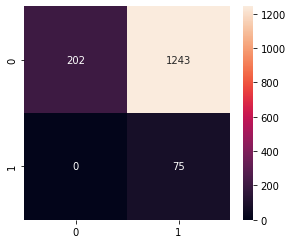

In [54]:
cm = confusion_matrix(y_test, y_test_pred_gr)

fig, axList = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(4.2, 3.5)

sns.heatmap(cm, annot=True, fmt='d')
ax.set(title="SVM")
plt.tight_layout()

[Text(111.6, 163.07999999999998, 'X[8] <= 0.5\ngini = 0.5\nsamples = 6740\nvalue = [3370, 3370]'),
 Text(55.8, 54.360000000000014, 'gini = 0.497\nsamples = 6250\nvalue = [2892, 3358]'),
 Text(167.39999999999998, 54.360000000000014, 'gini = 0.048\nsamples = 490\nvalue = [478, 12]')]

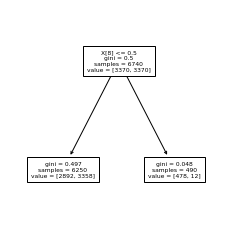

In [55]:
from sklearn import tree

plt.figure(figsize=(4, 4))
tree.plot_tree(GR.best_estimator_, fontsize=6)

Tree size 1207 19
Train and test errors
              train      test
accuracy   0.990059  0.853947
precision  0.986451  0.164384
recall     0.993769  0.480000
f1         0.990096  0.244898


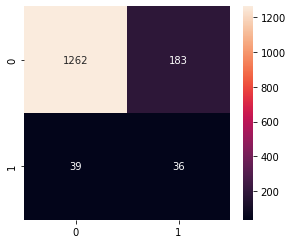

In [48]:
# Tuning a decision tree parameters to increase f1

from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='f1',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)
print("Tree size", GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth)

y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([
    measure_error(y_train, y_train_pred_gr, 'train'),
    measure_error(y_test, y_test_pred_gr, 'test')
    ],
    axis=1)

print("Train and test errors")
print(train_test_gr_error)

cm = confusion_matrix(y_test, y_test_pred_gr)

fig, axList = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(4.2, 3.5)

sns.heatmap(cm, annot=True, fmt='d')
ax.set(title="SVM")
plt.tight_layout()